In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

import numpy as np

import sys

In [4]:
sys.path.append("../../")

In [5]:
import logging

In [6]:
logger = logging.getLogger()

In [7]:
logger.setLevel(logging.INFO)

In [8]:
handler = logging.StreamHandler(sys.stdout)

In [9]:
logger.addHandler(handler)

In [10]:
from benchdata.amazon_google_products import AmazonGoogleData

In [11]:
data = AmazonGoogleData()

In [12]:
data.load()

In [13]:
data.default_fillna()

In [14]:
import fastText

In [15]:
from zipfile import ZipFile

In [62]:
fast_text_model_path = "../../data/pretrained/wiki-news-300d-1M-subword.bin"

In [63]:
model = fastText.load_model(fast_text_model_path)

In [64]:
model.get_word_vector("I")[:10]

array([-0.09542164,  0.06696253,  0.02227047, -0.00352219,  0.06714147,
        0.12475587,  0.03342403,  0.3083979 , -0.15685362, -0.0595038 ],
      dtype=float32)

In [29]:
from feature import pipelines

In [66]:
from models import scdv

In [67]:
data.KEY_COLUMN_PAIRS

[{'amazon': 'title', 'google': 'name'},
 {'amazon': 'description', 'google': 'description'},
 {'amazon': 'manufacturer', 'google': 'manufacturer'},
 {'amazon': 'price', 'google': 'price'}]

In [20]:
key_columns = [list(pair_dict.values()) for pair_dict in data.KEY_COLUMN_PAIRS[:-1]]

In [69]:
pipeline_func = lambda : pipelines.ConcatPipeline([("scdv", scdv.Scdv(word_emb_func=model.get_word_vector, n_components=10, sparse_threshold_p=0.04, verbose=2))])

In [70]:
pipeline_func_map_list = [pipeline_func for i in range(len(key_columns))]

In [71]:
extractor = pipelines.KeyColumnFeatureExtractor(key_column_correspondences=key_columns, pipeline_func_map_list=pipeline_func_map_list,  
                                                pipeline_save_dir="../result")

In [72]:
extractor.fit([data.amazon_df, data.google_products_df])

extracting features from ['title', 'name']
extracting features from ['title', 'name']
creating dictionary and computing idf...
creating dictionary and computing idf...
clustering in-vocabulary words (size: 5500) ...
clustering in-vocabulary words (size: 5500) ...
Initialization 0
  Iteration 0	 time lapse 0.86342s	 ll change inf
  Iteration 10	 time lapse 3.38334s	 ll change 0.01330
  Iteration 20	 time lapse 3.32513s	 ll change 0.01565
  Iteration 30	 time lapse 3.25625s	 ll change 0.01170
Initialization converged: True	 time lapse 11.15978s	 ll 978.24924
getting word-topic_vectors...
getting word-topic_vectors...
computing threshold to make sparse...
computing threshold to make sparse...
fitting has finished!!
fitting has finished!!
extracting features from ['description', 'description']
extracting features from ['description', 'description']
creating dictionary and computing idf...
creating dictionary and computing idf...
clustering in-vocabulary words (size: 15910) ...
clustering i

In [73]:
feature_matrixs = extractor.transform([data.amazon_df, data.google_products_df]) 

In [74]:
len(feature_matrixs)

2

In [22]:
import scipy as sp

In [23]:
import scipy.sparse as sparse

In [77]:
amazon_feature_matrix = sp.sparse.hstack(feature_matrixs[0])

In [78]:
google_feature_matrix = sp.sparse.hstack(feature_matrixs[1])

In [79]:
amazon_feature_matrix.shape

(1363, 9000)

In [80]:
from pathlib import Path

In [81]:
data_names = ["amazon", "google"] 
for i, feature_set in enumerate(feature_matrixs):
    for j, feature in enumerate(feature_set):
        sp.sparse.save_npz("../result/{}_{}_scdv.npz".format(data_names[i], key_columns[j][i]), feature)

In [82]:
!ls ../result

amazon_description_scdv.npz
amazon_manufacturer_scdv.npz
amazon_title_scdv.npz
description_description_concat_model.pickle
google_description_scdv.npz
google_manufacturer_scdv.npz
google_name_scdv.npz
manufacturer_manufacturer_concat_model.pickle
title_name_concat_model.pickle


# check cosine similarity of same entity

In [16]:
index_pair = data.get_perfect_match_index(True)

In [17]:
index_pair[:3]

array([[   0, 1878],
       [   2, 1881],
       [   3, 1879]])

In [18]:
data_names = ["amazon", "google"]

In [24]:
feature_matrixs = [[sparse.load_npz("../result/{}_{}_scdv.npz".format(data_name, key_columns[j][i])) for j in range(len(key_columns))] for 
                   i, data_name in enumerate(data_names)]

In [25]:
from scipy.spatial.distance import cosine

In [26]:
feature_matrixs = [sparse.hstack(features).tocsr() for features in feature_matrixs]

In [27]:
feature_matrixs[0].shape

(1363, 9000)

In [28]:
feature_matrixs[1].shape

(3226, 9000)

In [91]:
def distance_between_entity(row):
    return cosine(feature_matrixs[0][row[0]].todense(), feature_matrixs[1][row[1]].todense())

In [92]:
match_cosine_similariies = np.apply_along_axis(arr=index_pair, func1d=distance_between_entity, axis=1)

In [93]:
match_cosine_similariies[:10]

array([0.79246606, 0.19694187, 0.10017452, 0.4706178 , 0.32126646,
       0.15312591, 0.29731743, 0.12780001, 0.13305809, 0.82574749])

In [94]:
import itertools

In [95]:
import random

In [96]:
all_pair_nums = data.amazon_df.shape[0] * data.google_products_df.shape[0] 

In [97]:
all_pair_nums

4397038

In [98]:
unmatch_sampled_cosine_similarities = [cosine(feature_matrixs[0][i].todense(), feature_matrixs[1][j].todense()) for i, j in itertools.product(range(data.amazon_df.shape[0]), range(data.google_products_df.shape[0]))
                                if (not np.any(np.where((index_pair[:, 0] == i) & (index_pair[:, 1] == j)))) and random.randrange(0, 100) == 0
                              ]

In [99]:
unmatch_sampled_cosine_similarities = np.vstack(unmatch_sampled_cosine_similarities)

In [100]:
unmatch_sampled_cosine_similarities.shape

(44228, 1)

In [1]:
import seaborn as sns

In [102]:
import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


([array([0.86615756, 2.44517046, 1.76297556, 1.18809223, 1.13443645,
         0.86615756, 0.551888  , 0.44457645, 0.45990667, 0.24528356]),
  array([0.04596155, 1.02399632, 1.83192829, 1.62577721, 1.1391255 ,
         0.84510675, 0.74372098, 0.82235128, 0.87845141, 1.0082252 ])],
 array([0.01081705, 0.11117186, 0.21152667, 0.31188148, 0.41223629,
        0.5125911 , 0.61294591, 0.71330072, 0.81365553, 0.91401034,
        1.01436515]),
 <a list of 2 Lists of Patches objects>)

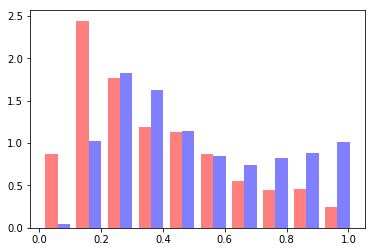

In [103]:
plt.hist([match_cosine_similariies, unmatch_sampled_cosine_similarities], color=['r','b'], alpha=0.5, normed=True)

It seems there are in the samller than 0.2 but larger than 0.8.   

# k-nn

In [29]:
from sklearn.neighbors import NearestNeighbors

In [30]:
import numpy as np

In [31]:
from feature import pipelines

In [32]:
from sklearn.decomposition import TruncatedSVD

In [33]:
svd_pipelines = pipelines.ConcatPipeline([("svd", TruncatedSVD(n_components=100))])

In [34]:
compress_feature = svd_pipelines.fit_transform(feature_matrixs)

In [35]:
knn_pipeline = pipelines.ConcatPipeline([("knn", NearestNeighbors(n_neighbors=30, algorithm='ball_tree'))])

In [36]:
knn_pipeline.fit(compress_feature)

ConcatPipeline(memory=None,
        steps=[('knn', NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=30, p=2, radius=1.0))])

In [37]:
type(compress_feature[0])

numpy.ndarray

In [38]:
distances, indices = knn_pipeline.steps[0][1].kneighbors(np.vstack(compress_feature))

In [39]:
amazon_size = data.amazon_df.shape[0]

In [40]:
nn_offsets = np.ones((30)) * amazon_size

In [41]:
def in_neighbor(row):
    nns = indices[row[0]]
    return np.isin(row[1], nns - nn_offsets)

In [42]:
in_knns = np.apply_along_axis(arr=index_pair, func1d=in_neighbor, axis=1)

In [43]:
## ratio of the neghbors including the matched entity
in_knns.sum() / in_knns.shape[0]

0.06538461538461539

knn with Scdv features compressed by TruncatedSVD cannot find most of the correct neighbors (= matched entities) for each instance.